<a href="https://colab.research.google.com/github/rioAgustian/Fisika-Komputasi/blob/main/double_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Circle
from matplotlib import animation
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [35]:
# simbol yang digunakan untuk komputasi simbolik
t, g, m1, m2, L1, L2 = sp.symbols("t g m1 m2 L1 L2")

In [36]:
# theta adalah fungsi waktu
the1, the2 = sp.symbols(r"\theta_1 \theta_2", cls=sp.Function)
the1 = the1(t)
the2 = the2(t)

In [37]:
# mencari turunan pertama dan kedua dari theta terhadap t
the1_d  = sp.diff(the1, t)
the2_d  = sp.diff(the2, t)
the1_dd = sp.diff(the1_d, t)
the2_dd = sp.diff(the2_d, t)

In [38]:
# hubungan koordinat kartesian dengan theta dan L
x1 =  L1*sp.sin(the1)
y1 = -L1*sp.cos(the1)
x2 =  L1*sp.sin(the1) + L2*sp.sin(the2)
y2 = -L1*sp.cos(the1) - L2*sp.cos(the2)

In [39]:
# energi kinetik
T1 = 1/2 * m1 * (sp.diff(x1, t)**2 + sp.diff(y1, t)**2)
T2 = 1/2 * m2 * (sp.diff(x2, t)**2 + sp.diff(y2, t)**2)
T  = T1 + T2

# energi potensial
V1 = m1 * g * y1
V2 = m2 * g * y2
V  = V1 + V2

# sistem Lagrange
L = T - V 

## Tentang persamaan gerak

Persamaan gerak double pendulum di sini dicari dengan menggunakan mekanika Lagrange. 

Jika $T$ adalah energi kinetik dan $V$ adalah energi potensial dan $L = T - V$, 


maka persamaan gerak dapat dicari dengan menyelesaiakan persamaan diferensial berikut.

\begin{align}
\frac{∂L}{\partial \theta_1} - \frac{\partial L}{\partial t}\left(\frac{\partial L}{\partial \dot{\theta_1} } \right) = 0 \\
\frac{∂L}{\partial \theta_2} - \frac{\partial L}{\partial t}\left(\frac{\partial L}{\partial \dot{\theta_2} } \right) = 0
\end{align}

In [40]:
# untuk theta 1
LE1 = sp.diff(L, the1) - sp.diff(sp.diff(L, the1_d), t).simplify()

# untuk theta 2
LE2 = sp.diff(L, the2) - sp.diff(sp.diff(L, the2_d), t).simplify()

In [41]:
# menyelesaikan d^2(theta)/dt^2
solusi = sp.solve([LE1, LE2], (the1_dd, the2_dd),
                  simplify=False, rational=False)

In [42]:
# dw/dt atau d^2(theta)/dt^2
dw1dt_f = sp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), solusi[the1_dd])
dw2dt_f = sp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), solusi[the2_dd])

# d(theta)/dt
dthe1dt_f = sp.lambdify(the1_d, the1_d)
dthe2dt_f = sp.lambdify(the2_d, the2_d)

In [43]:
# fungsi untuk feed odeint
def dSdt(S, t, g, m1, m2, L1, L2):
  the1, w1, the2, w2 = S
  return [dthe1dt_f(w1),
          dw1dt_f(t,g,m1,m2,L1,L2,the1,the2, w1, w2),
          dthe2dt_f(w2),
          dw2dt_f(t,g,m1,m2,L1,L2,the1,the2, w1, w2)]

In [44]:
# pewaktuan
t = np.linspace(0, 40, 1001)

# argumen
g  = 9.81
m1 = 2
m2 = 1
L1 = 2
L2 = 1

# initial condition
the1 =  1
the2 = -1
w1 = -3
w2 =  5

# merapikan argumen dan parameter
args = (g, m1, m2, L1, L2)
S0   = [the1, w1, the2, w2]

In [45]:
# menggunakan scipy.integrate.odeint
sol = odeint(dSdt, y0=S0, t=t, args=args)
the1 = sol.T[0]
the2 = sol.T[2]

In [46]:
# mengubah koordinat polar ke kartesian
def xy(t, the1, the2, L1, L2):
  return [ L1*np.sin(the1),
          -L1*np.cos(the1),
           L1*np.sin(the1) + L2*np.sin(the2),
          -L1*np.cos(the1) - L2*np.cos(the2)]

# koordinat massa 1 dan 2
x1, y1, x2, y2 = xy(t, sol.T[0], sol.T[2], L1, L2)

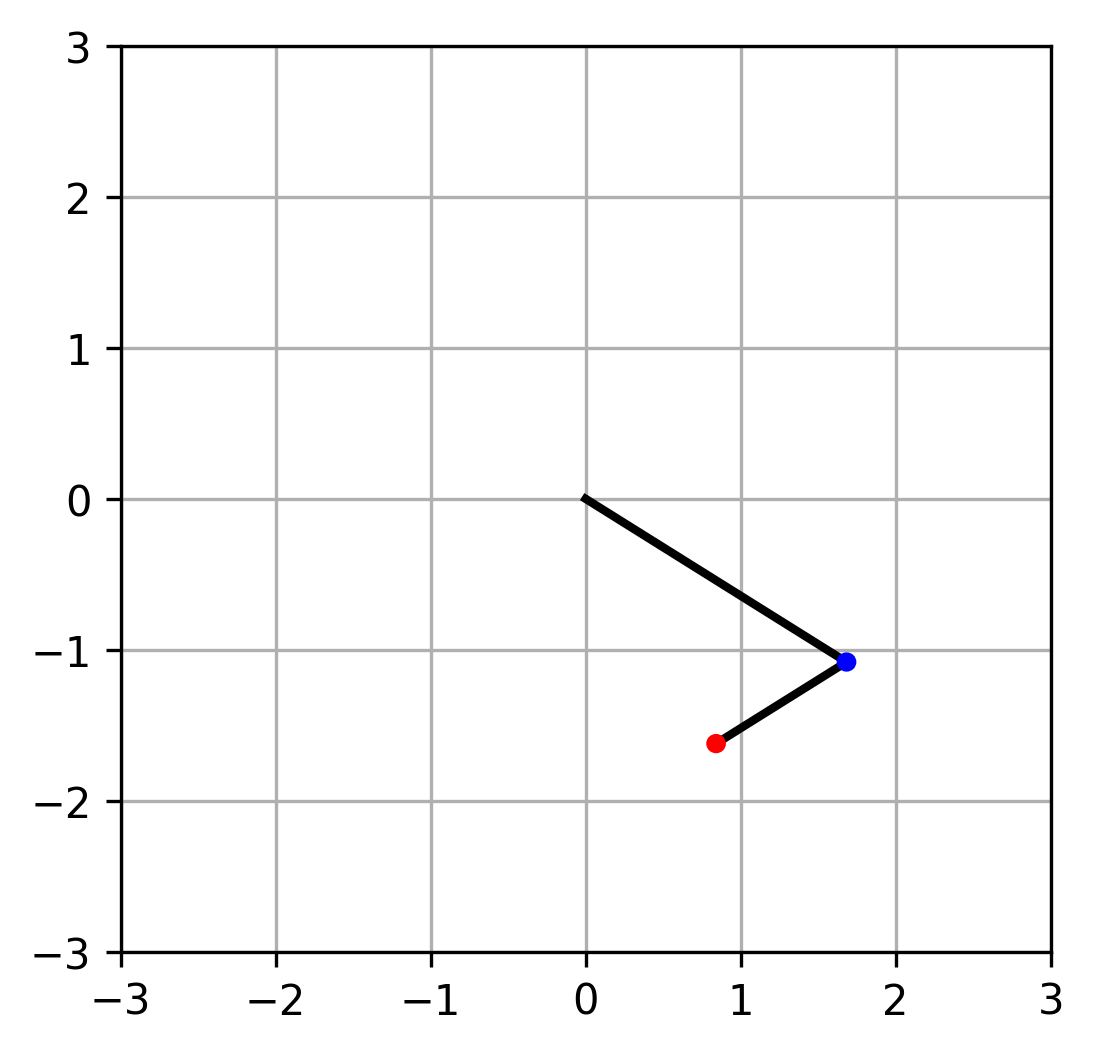

In [47]:
# membuat animasi
dt = 0.01
r = 0.05
trail_secs = 1
max_trail = int(trail_secs / dt)

def animate(i):
    plt.cla()
    plt.grid()
    ax.set_ylim(-3, 3)
    ax.set_xlim(-3, 3)
    ax.plot([0, x1[i], x2[i]], # ini massa 1
            [0, y1[i], y2[i]], # ini massa 2
            lw=2, c='k')
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='g', solid_capstyle='butt',
                lw=2, alpha=alpha)

fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)

# uncomment untuk melihat keluaran
# ani.save("pen.mp4", writer="ffmpeg", fps=25)